<a href="https://colab.research.google.com/github/tejas-srikanth/Exercise-Tracker/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [23]:
torch.__version__

'1.6.0+cu101'

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [26]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

mkdir: cannot create directory ‘data_faces’: File exists


In [27]:
dataroot = "./data_faces"

workers = 2

batch_size = 128

image_size = 64

nc = 3

nz = 100

ngf = 64

ndf = 64

num_epochs = 5

lr = 0.0002

beta1 = 0.5

ngpu = 1

In [28]:
import zipfile
import os

In [29]:
with zipfile.ZipFile("celeba.zip", mode='r') as zip_ref:
  zip_ref.extractall("data_faces/")

In [30]:
print(len(os.listdir("data_faces/img_align_celeba")))

202599


In [31]:
!pip install Pillow --upgrade
!pip install PIL
!pip install image
import PIL.Image as Image

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.2.0)
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [32]:
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height+crop_size, offset_width:offset_width+crop_size]

transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Lambda(crop),
                  transforms.ToPILImage(),
                  transforms.Resize(re_size, interpolation=Image.BICUBIC),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root = dataroot, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [33]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


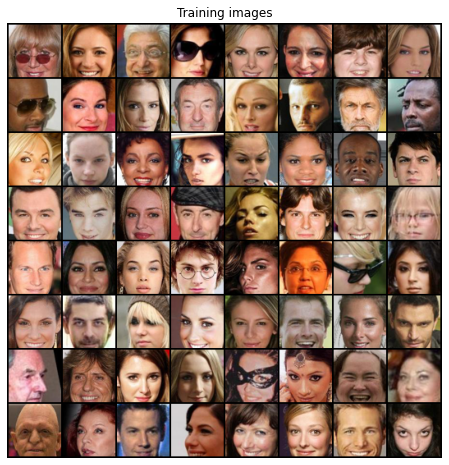

In [34]:
batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.title("Training images")
plt.axis("off")
plt.imshow(np.transpose(make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))



# Weight Init Function

In [35]:
def weights_init(m):
  classname = m.__class__.__name__

  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

# Initialize Generator

In [36]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu

    self.main = nn.Sequential(

      nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf*8),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf*4),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf*2),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
      nn.BatchNorm2d(nc),
      nn.Tanh()

    )
  def forward(self, input):
    return self.main(input)

In [37]:
netG = Generator(ngpu).to(device)
if (device.type=="cuda" and ngpu > 1):
  nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Initialize Discriminator

In [38]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self, input):
    return self.main(input)

In [39]:
netD = Discriminator(ngpu).to(device)
if (device.type == "cuda" and ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Loss Function

In [40]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Train The Networks

In [41]:
img_list = []
generator_losses = []
discriminator_losses = []
iters = 0
epochs = 5


for epoch in range(epochs):
  for i, data in enumerate(dataloader, 0):
    
    netD.zero_grad()

    ##TRAIN THE DISCRIMINATOR ON REAL IMAGES##
    real_data = data[0].to(device)
    b_size = real_data.size(0)
    labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    output = netD(real_data).view(-1)
    errD_real = criterion(output, labels)

    errD_real.backward()
    D_x = output.mean().item()

    ##TRAIN THE DISCRIMINATOR ON GENERATED IMAGES##
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)

    labels.fill_(fake_label)

    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, labels)

    errD_fake.backward()
    D_G_z1 = output.mean().item()

    ##ADD THE GRADIENTS FROM THE REAL AND FAKE MINI-BATCHES##
    ##THEN UPDATE LEARNABLES##
    errD = errD_real + errD_fake
    optimizerD.step()

    ##TRAIN THE GENERATOR##
    netG.zero_grad()

    labels.fill_(real_label)

    output = netD(fake).view(-1)
    errG = criterion(output, labels)
    errG.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step()

    if i % 150 == 0:
      print(f'[{epoch+1}/{epochs}][{i}/{len(dataloader)}]\tLoss D: {errD.item():.4f}\tLoss G: {errG.item():.4f}\tD(x): {D_x}\tD(G(x)): {D_G_z1}/{D_G_z2}')
    
    generator_losses.append(errG.item())
    discriminator_losses.append(errD.item())

    if (iters % 500 == 0) or (epoch == num_epochs - 1 and i == len(dataloader) - 1):
      with torch.no_grad():
        img = netG(fixed_noise).detach().cpu()
      img_list.append(make_grid(img, padding=2, normalize=True))
    
    iters += 1

    

[1/5][0/1583]	Loss D: 2.0362	Loss G: 1.9735	D(x): 0.2508678734302521	D(G(x)): 0.2659000754356384/0.18521089851856232
[1/5][150/1583]	Loss D: 2.0023	Loss G: 9.2737	D(x): 0.3575058579444885	D(G(x)): 0.0002949950867332518/0.001381480135023594
[1/5][300/1583]	Loss D: 0.3561	Loss G: 4.5958	D(x): 0.8443005084991455	D(G(x)): 0.09366324543952942/0.017504286020994186
[1/5][450/1583]	Loss D: 0.3285	Loss G: 4.9229	D(x): 0.9358641505241394	D(G(x)): 0.1881428360939026/0.020244861021637917
[1/5][600/1583]	Loss D: 0.6493	Loss G: 5.5215	D(x): 0.783959150314331	D(G(x)): 0.2329884171485901/0.007143722381442785
[1/5][750/1583]	Loss D: 0.5842	Loss G: 6.0502	D(x): 0.8435102701187134	D(G(x)): 0.26357901096343994/0.004309181123971939
[1/5][900/1583]	Loss D: 0.3082	Loss G: 6.0189	D(x): 0.7961797118186951	D(G(x)): 0.022811757400631905/0.006029017269611359
[1/5][1050/1583]	Loss D: 0.3295	Loss G: 5.6213	D(x): 0.9354687333106995	D(G(x)): 0.19572781026363373/0.007922161370515823
[1/5][1200/1583]	Loss D: 0.4192	Los

In [42]:
torch.save(netG.state_dict(), '/content/drive/My Drive/Colab Notebooks/DCGAN_celeb/generator.pt')
torch.save(netD.state_dict(), '/content/drive/My Drive/Colab Notebooks/DCGAN_celeb/discriminator.pt')

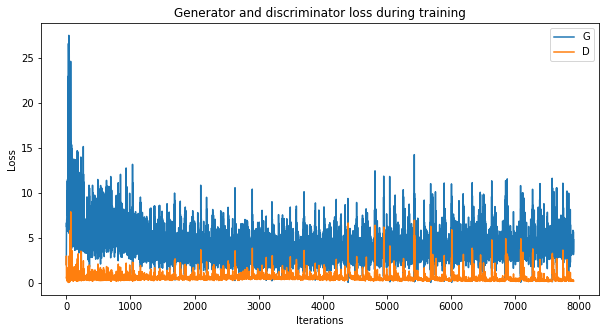

In [43]:
plt.figure(figsize=(10, 5))
plt.title("Generator and discriminator loss during training")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(generator_losses, label="G")
plt.plot(discriminator_losses, label="D")
plt.legend()
plt.show()

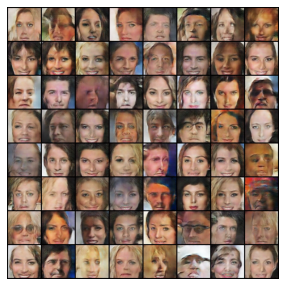

In [44]:
fig = plt.figure(figsize=(10, 5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

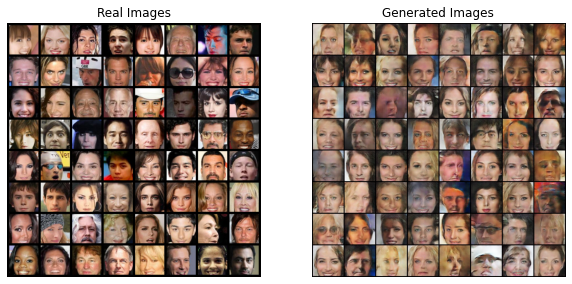

In [48]:
batch = next(iter(dataloader))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()